# House Price Code

## Imports and Load Data

In [1]:
#Imports
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [2]:
# Import data
train = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/train.csv'
df_train_raw = pd.read_csv(train)

test_x = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/test.csv'
df_test_x_raw = pd.read_csv(test_x)

test_y = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/sample_submission.csv'
df_test_y_raw= pd.read_csv(test_y)

In [3]:
# Merge train dataset and test dataset
df_test_raw = pd.merge(df_test_x_raw, df_test_y_raw, on='Id')
df_raw = pd.concat([df_train_raw,df_test_raw])

## Clean Data

In [4]:
# From the data description, when these values are nan, the property does not contain installment. 
# So we will change these features from nan to None
na_none = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [5]:
# Check percentage of missing data for each feature in train dataset
na_col = [i for i in df_raw.columns if df_raw[i].isnull().sum() > 0 and i not in na_none]
print((df_raw[na_col].isna().sum()/len(df_raw.Id)).sort_values())

BsmtUnfSF       0.000343
GarageCars      0.000343
KitchenQual     0.000343
Electrical      0.000343
TotalBsmtSF     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
SaleType        0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
BsmtFinSF1      0.000343
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
MSZoning        0.001370
MasVnrArea      0.007879
MasVnrType      0.008222
GarageYrBlt     0.054471
LotFrontage     0.166495
dtype: float64


In [6]:
def clean_df(df):
    
    for col in df.columns:
        
        # Replace the missing value to None if feature is in the na_none list
        if col in na_none:
            df[col] =  df[col].fillna('None')
        
        # Drop features that contain more than 20% missing values
        elif df[col].isnull().sum() / df.shape[0] > 0.1:
            df = df.drop(col, axis=1)
            
    return df

In [7]:
df_cleaned = clean_df(df_raw) # drop columns and replace nan with none

df_cleaned = df_cleaned.dropna() #drop any row with missing data

In [8]:
#Drop ID column
df_cleaned = df_cleaned.drop('Id', axis=1)

# split train dataset
df_x = df_cleaned.drop(columns='SalePrice')
df_y = df_cleaned['SalePrice']

df_x.shape

(2726, 78)

In [9]:
df_cleaned

MSSubClass MSZoning  LotArea Street Alley LotShape LandContour  \
0             60       RL     8450   Pave  None      Reg         Lvl   
1             20       RL     9600   Pave  None      Reg         Lvl   
2             60       RL    11250   Pave  None      IR1         Lvl   
3             70       RL     9550   Pave  None      IR1         Lvl   
4             60       RL    14260   Pave  None      IR1         Lvl   
...          ...      ...      ...    ...   ...      ...         ...   
1451          20       RL    13384   Pave  None      Reg         Lvl   
1452         160       RM     1533   Pave  None      Reg         Lvl   
1455         160       RM     1894   Pave  None      Reg         Lvl   
1456          20       RL    20000   Pave  None      Reg         Lvl   
1458          60       RL     9627   Pave  None      Reg         Lvl   

     Utilities LotConfig LandSlope  ... PoolArea PoolQC Fence MiscFeature  \
0       AllPub    Inside       Gtl  ...        0   None  None        None   
1       AllPub       FR2       Gtl  ...        0   None  None        None   
2       AllPub    Inside       Gtl  ...        0   None  None        None   
3       AllPub    Corner       Gtl  ...        0   None  None        None   
4       AllPub       FR2       Gtl  ...        0   None  None        None   
...        ...       ...       ...  ...      ...    ...   ...         ...   
1451    AllPub    Inside       Mod  ...        0   None  None        None   
1452    AllPub    Inside       Gtl  ...        0   None  None        None   
1455    AllPub    Inside       Gtl  ...        0   None  None        None   
1456    AllPub    Inside       Gtl  ...        0   None  None        None   
1458    AllPub    Inside       Mod  ...        0   None  None        None   

     MiscVal  MoSold  YrSold  SaleType  SaleCondition      SalePrice  
0          0       2    2008        WD         Normal  208500.000000  
1          0       5    2007        WD         Normal  181500.000000  
2          0       9    2008        WD         Normal  223500.000000  
3          0       2    2006        WD        Abnorml  140000.000000  
4          0      12    2008        WD         Normal  250000.000000  
...      ...     ...     ...       ...            ...            ...  
1451       0       5    2006        WD         Normal  188506.431412  
1452       0      12    2006        WD        Abnorml  172917.456816  
1455       0       4    2006        WD        Abnorml  164788.778231  
1456       0       9    2006        WD        Abnorml  219222.423400  
1458       0      11    2006        WD         Normal  187741.866657  

[2726 rows x 79 columns]

## Exploratory Data Analysis

In [10]:
## y-test summary stats
feature_names = list(df_cleaned.columns)
print("List of features:", feature_names)

List of features: ['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', '

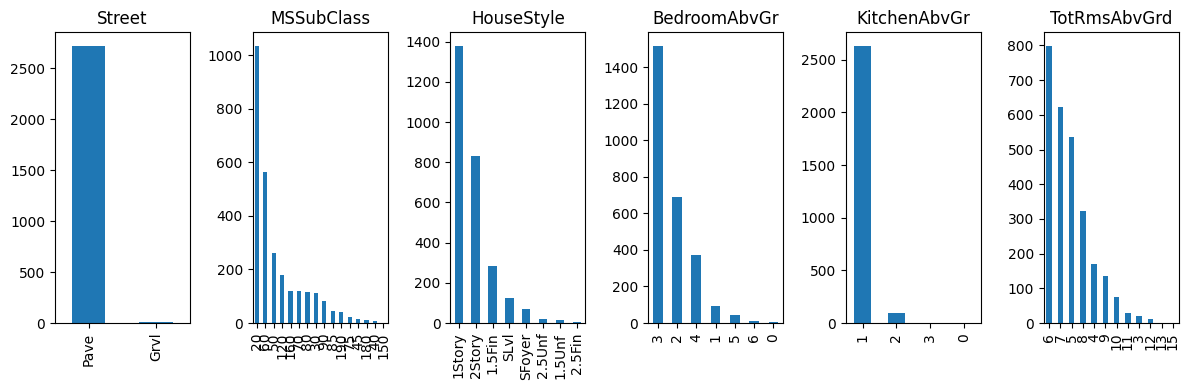

In [11]:
# Plot a small multiple of bar charts
fig, ax = plt.subplots(1, 6, figsize=(12, 4))
for i, var in enumerate(['Street', 'MSSubClass', 'HouseStyle', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']):
    df_cleaned[var].value_counts().plot(kind='bar', ax=ax[i])
    ax[i].set_title(var)

plt.tight_layout()
plt.show()

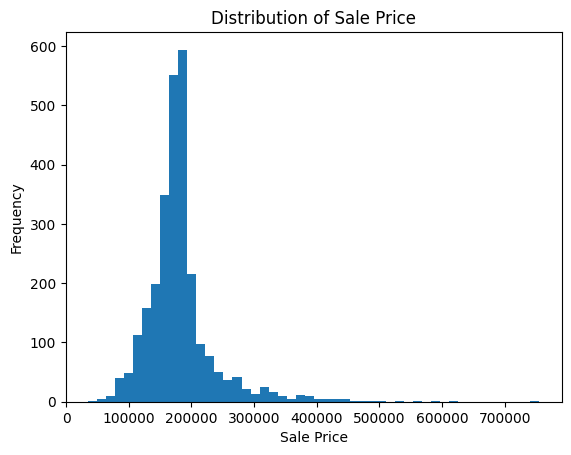

In [12]:
# assume 'SalePrice' is the target variable in your dataframe
y = df_cleaned['SalePrice']

# create a histogram of the target variable
plt.hist(y, bins=50)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Price')
plt.show()

In [13]:
#Calculating y-test summary stats
mean = np.mean(df_y)
median = np.median(df_y)
std_dev = np.std(df_y)
skewness = df_y.skew()
kurtosis = df_y.kurtosis()

print("Mean: ", mean)
print("Median: ", median)
print("Standard Deviation: ", std_dev)
print("Skewness: ", skewness)
print("Kurtosis: ", kurtosis)

Mean:  182095.9275635585
Median:  177283.0649785215
Standard Deviation:  57113.81445708513
Skewness:  2.7171520639784874
Kurtosis:  15.42907052826676


## Encode Data

In [14]:
#List categorical features
categorical_feats = df_x.select_dtypes('object').columns
categorical_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [15]:
# Encode variables

# Target Encode features that have many groups / are not ordinal
target_cat_feats = ['GarageType', 'Functional', 'Electrical', 'SaleCondition', 'SaleType', 'Heating', 'BsmtFinType2', 'BsmtFinType1', 'Foundation', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType']
target_encoder = ce.TargetEncoder(cols=target_cat_feats)

target_encoder.fit(df_x, df_y)
df_x_te = target_encoder.transform(df_x)

# Ordinal Encode features with few groups / have a natural order
ordinal_cat_feats = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'KitchenQual', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageFinish', 'CentralAir', 'HeatingQC', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond']
ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_cat_feats)

ordinal_encoder.fit(df_x_te, df_y)
df_x_encoded = ordinal_encoder.transform(df_x_te)

In [16]:
df_x_encoded

MSSubClass       MSZoning  LotArea  Street  Alley  LotShape  \
0             60  188216.590793     8450       1      1         1   
1             20  188216.590793     9600       1      1         1   
2             60  188216.590793    11250       1      1         2   
3             70  188216.590793     9550       1      1         2   
4             60  188216.590793    14260       1      1         2   
...          ...            ...      ...     ...    ...       ...   
1451          20  188216.590793    13384       1      1         1   
1452         160  151286.299685     1533       1      1         1   
1455         160  151286.299685     1894       1      1         1   
1456          20  188216.590793    20000       1      1         1   
1458          60  188216.590793     9627       1      1         1   

      LandContour  Utilities      LotConfig  LandSlope  ...  ScreenPorch  \
0               1          1  179629.124775          1  ...            0   
1               1          1  181436.760833          1  ...            0   
2               1          1  179629.124775          1  ...            0   
3               1          1  182996.979724          1  ...            0   
4               1          1  181436.760833          1  ...            0   
...           ...        ...            ...        ...  ...          ...   
1451            1          1  179629.124775          2  ...            0   
1452            1          1  179629.124775          1  ...            0   
1455            1          1  179629.124775          1  ...            0   
1456            1          1  179629.124775          1  ...            0   
1458            1          1  179629.124775          2  ...            0   

      PoolArea  PoolQC  Fence  MiscFeature  MiscVal  MoSold  YrSold  \
0            0       1      1            1        0       2    2008   
1            0       1      1            1        0       5    2007   
2            0       1      1            1        0       9    2008   
3            0       1      1            1        0       2    2006   
4            0       1      1            1        0      12    2008   
...        ...     ...    ...          ...      ...     ...     ...   
1451         0       1      1            1        0       5    2006   
1452         0       1      1            1        0      12    2006   
1455         0       1      1            1        0       4    2006   
1456         0       1      1            1        0       9    2006   
1458         0       1      1            1        0      11    2006   

           SaleType  SaleCondition  
0     178231.141232  178717.795783  
1     178231.141232  178717.795783  
2     178231.141232  178717.795783  
3     178231.141232  165527.980749  
4     178231.141232  178717.795783  
...             ...            ...  
1451  178231.141232  178717.795783  
1452  178231.141232  165527.980749  
1455  178231.141232  165527.980749  
1456  178231.141232  165527.980749  
1458  178231.141232  178717.795783  

[2726 rows x 78 columns]

In [17]:
# Categorical features have been removed
df_x_encoded.select_dtypes('object').columns

Index([], dtype='object')

In [18]:
# We will probably to PCA, so looking at correlations is probably not too important

#plot correlation matrix
plt.figure(figsize=(100,100))
corr_matrix = df_x_encoded.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Take absolute values of correlations and select upper triangle of correlation matrix
upper_matrix = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
correlated_features = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.9)]
correlated_features

['Exterior2nd', 'SaleCondition']

## Sort, Split and Scale Data

In [19]:
# Sort Data Chronologically (preventing data leakage)
df_x_encoded = df_x_encoded.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)

# Sort df_x_encoded by YearSold
df_x_sorted = df_x_encoded.sort_values(by='YrSold')

# Set the index of df_y to match the sorted index of df_x_sorted
df_y_sorted = df_y.loc[df_x_sorted.index]

In [20]:
# Split Data into Dev and Test
X_dev, X_test, y_dev, y_test = train_test_split(df_x_sorted, df_y_sorted, test_size=0.2, shuffle=False)

# Split Dev into Train and Test
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, shuffle=False)

In [21]:
#Scale Data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_val_scaled = scale.transform(X_val)
X_test_scaled = scale.fit_transform(X_test)

## GMM

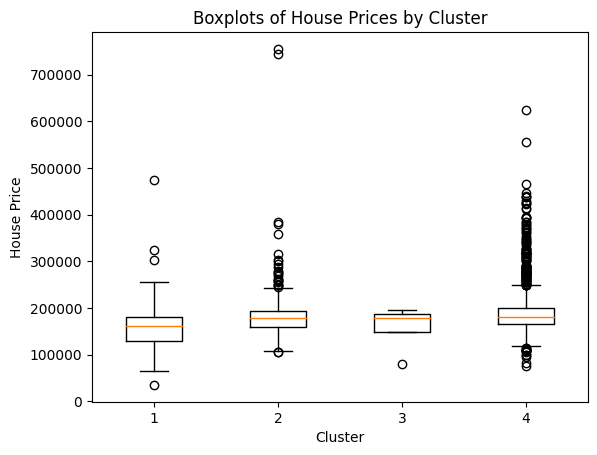

Cluster 1: 393 data points
Cluster 2: 349 data points
Cluster 3: 5 data points
Cluster 4: 997 data points


In [22]:
#Gaussian Mixture Modelling
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_train_scaled)

# Predict the labels for the data
labels = gmm.predict(X_train_scaled)

# Create a list of y values for each cluster
y_cluster = [y_train[labels == i] for i in range(gmm.n_components)]

# Sort clusters in ascending order (by median)
sorted_y_cluster = sorted(y_cluster, key=lambda x: np.median(x))

# Boxplot of clusters
plt.boxplot(sorted_y_cluster)
plt.title("Boxplots of House Prices by Cluster")
plt.xlabel("Cluster")
plt.ylabel("House Price")
plt.show()

# Count number of points in each cluster
for i in range(0,len(sorted_y_cluster)):
    print("Cluster " + str(i+1) + ": " + str(len(sorted_y_cluster[i])) + " data points")  

## PCA

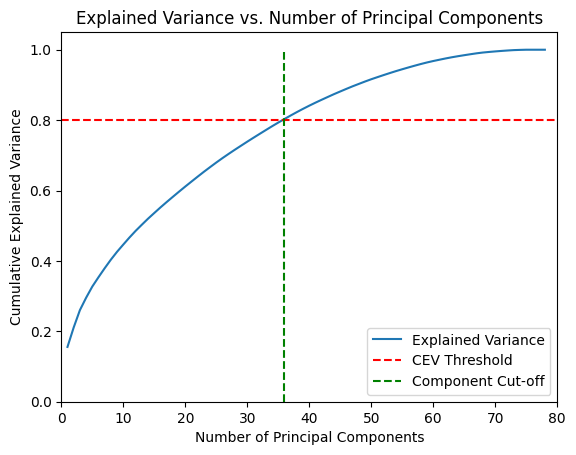

In [23]:
from sklearn.decomposition import PCA

#Apply PCA to scaled data and compute the variance ratio:
pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

#Plot the explained variance ratio as a function of the number of principal components:
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), label='Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(y=0.8, xmin=0, xmax=80, linestyles='dashed', colors='red', label='CEV Threshold')
plt.vlines(x=36, ymin=0, ymax=1, linestyles='dashed', colors='green', label='Component Cut-off')
plt.xlim((0,80))
plt.ylim((0,1.05))
plt.legend(loc='lower right')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [24]:
#Determine the number of PC that explain a sufficient proportion of the variance
n_components = np.where(np.cumsum(explained_variance_ratio) >= 0.80)[0][0] + 1

In [25]:
#Perform PCA with the optimal number of principal components:
pca_optimal = PCA(n_components=n_components)

X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_val_pca = pca_optimal.fit_transform(X_val_scaled)
X_test_pca = pca_optimal.fit_transform(X_test_scaled)

In [26]:
# Create a DataFrame with principal components and columns named 'PC1', 'PC2', etc.
df_principal_components = pd.DataFrame(X_train_pca, columns=['PC' + str(i + 1) for i in range(n_components)])
df_principal_components

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     2.434795  0.679399  1.674223 -1.014814  1.041730  0.959143 -1.258774   
1    -3.282254 -0.557613 -1.479033 -0.952361 -0.561949  2.763982  0.569865   
2     3.240687 -1.633721  1.900740 -1.645456  0.144284 -0.065539  0.030538   
3    -1.099800  0.347716 -1.021045 -0.534224 -0.615302  0.392106 -0.320470   
4    -0.045683  0.513860  1.551767  0.189099  0.205636  1.495576 -0.067626   
...        ...       ...       ...       ...       ...       ...       ...   
1739 -1.476109  1.302505  3.137905 -2.390382  0.271888 -2.275420 -0.993502   
1740  0.011745  1.777174 -1.109957 -1.305218 -0.208743  0.137291  0.261174   
1741 -4.785574 -0.576600  0.256476  2.446613 -0.461789 -1.256105  0.689793   
1742 -4.320460 -0.006660  0.576049  3.211030 -0.287379 -2.733579  3.317782   
1743 -0.048416  3.936393 -3.623486 -3.699007  0.042366 -0.566705 -1.237266   

           PC8       PC9      PC10  ...      PC27      PC28      PC29  \
0    -1.128394  0.594010  1.141932  ... -0.035374  0.342879 -0.816802   
1     0.685407 -0.231020  0.863211  ... -0.435065 -0.676637  1.509135   
2    -0.198186  0.172937 -0.377002  ...  0.628485  0.099118 -0.159213   
3     1.150040 -0.894230  0.004295  ...  0.869896 -0.244403  0.049173   
4     0.083807 -0.414480 -0.390746  ...  1.540972 -0.378690  0.877633   
...        ...       ...       ...  ...       ...       ...       ...   
1739 -1.088721  1.802352  1.839994  ...  0.557420 -3.708047 -0.332091   
1740  1.160174 -0.042934 -0.427738  ... -0.868966 -0.791467  0.127754   
1741 -1.824416  1.779316 -0.378775  ...  0.390335  0.177347 -0.703279   
1742 -5.272169  0.248865 -4.069275  ... -2.338445 -2.084710 -0.206231   
1743 -3.751359  6.093431  2.116973  ... -0.542697  0.484207 -2.025914   

          PC30      PC31      PC32      PC33      PC34      PC35      PC36  
0     0.578046 -0.902082 -0.622817 -0.078476  0.610011 -1.641731 -0.752313  
1    -0.924203 -1.417522 -0.205926  1.187506 -1.014612 -0.629962 -0.896951  
2    -0.358979 -0.146177  0.369945  0.117910 -0.052575 -0.127761 -0.037326  
3     0.576403  1.310140 -0.355542 -0.413633 -1.046543 -0.935504 -0.174062  
4    -0.616210 -0.007412 -0.424546  0.064610  0.675636  0.006490  0.024111  
...        ...       ...       ...       ...       ...       ...       ...  
1739 -0.444102 -0.677410  4.798686 -0.032388 -1.970657 -0.502577 -1.009633  
1740 -0.470720  2.515615 -0.484659 -1.346975 -0.355435 -0.404352 -0.556087  
1741 -1.033638  1.337557 -0.759442  1.626253  0.631673 -0.717297 -0.417725  
1742  0.290823 -3.476552 -4.387033 -0.117815 -1.062121 -1.530373  0.106233  
1743 -0.148529 -0.508524  0.606132  0.618562  1.277963  0.323048  1.423651  

[1744 rows x 36 columns]

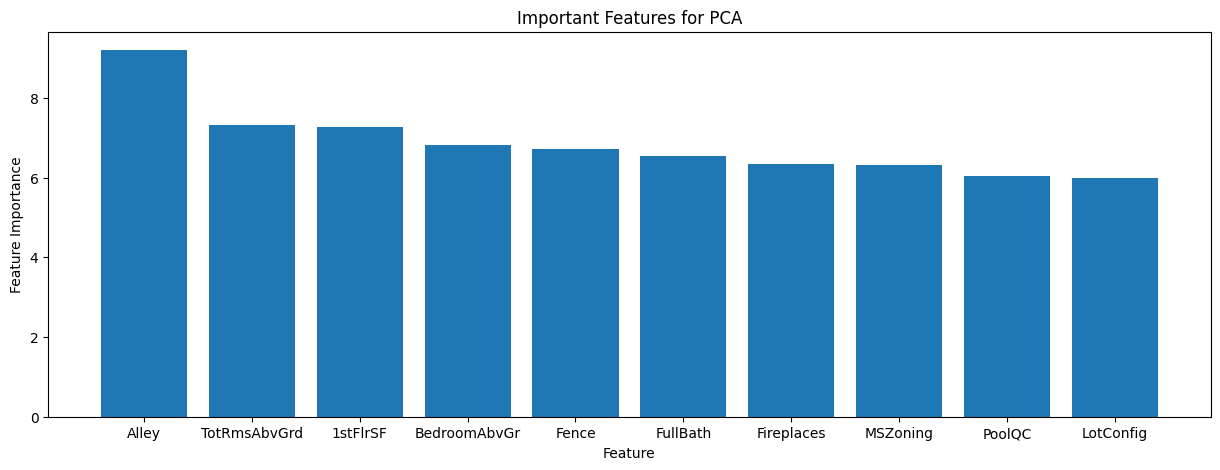

In [27]:
#Important Features for PCA

#Get eigenvectors and eigenvalues
eigenvectors = pca.components_[:, :n_components]
eigenvalues = pca.explained_variance_[:n_components].reshape(-1, 1)

#Calculate feature importance
feature_imp = np.zeros((eigenvectors.shape[0]))
for i in range(0,len(eigenvalues)):
    feature_imp += np.abs(eigenvalues[i] * eigenvectors[:,i])

# Get the indices that would sort the feature_imp in ascending order
sort_ind = np.argsort(feature_imp)

# Select the last 10 indices (corresponding to the largest elements)
largest_feat_ind = sort_ind[-10:]
largest_feat_ind = largest_feat_ind[::-1]  # Reverse order to get largest to smallest

# Get the top 10 elements and their indices
most_imp = feature_imp[largest_feat_ind]

# Get a list of column names corresponding to the selected features
feat_names = list(df_x_encoded.columns[largest_feat_ind])

# Create the bar plot
plt.figure(figsize=(15,5))
plt.bar(range(len(most_imp)), most_imp)
plt.xticks(range(len(feat_names)), feat_names)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Important Features for PCA')
plt.show()

## Numan - Applying ML Techniques

### Random Forest on original data

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV


rfr_pipe = make_pipeline(RandomForestRegressor())
rfr_pipe.fit(X_train, y_train)
y_pred_rfr_base = rfr_pipe.predict(X_test)
print('Root Mean Squared Logarithmic Error (RMSE):', mean_squared_log_error(y_test, y_pred_rfr_base, squared=False))

Root Mean Squared Logarithmic Error (RMSE): 0.19863996305650833


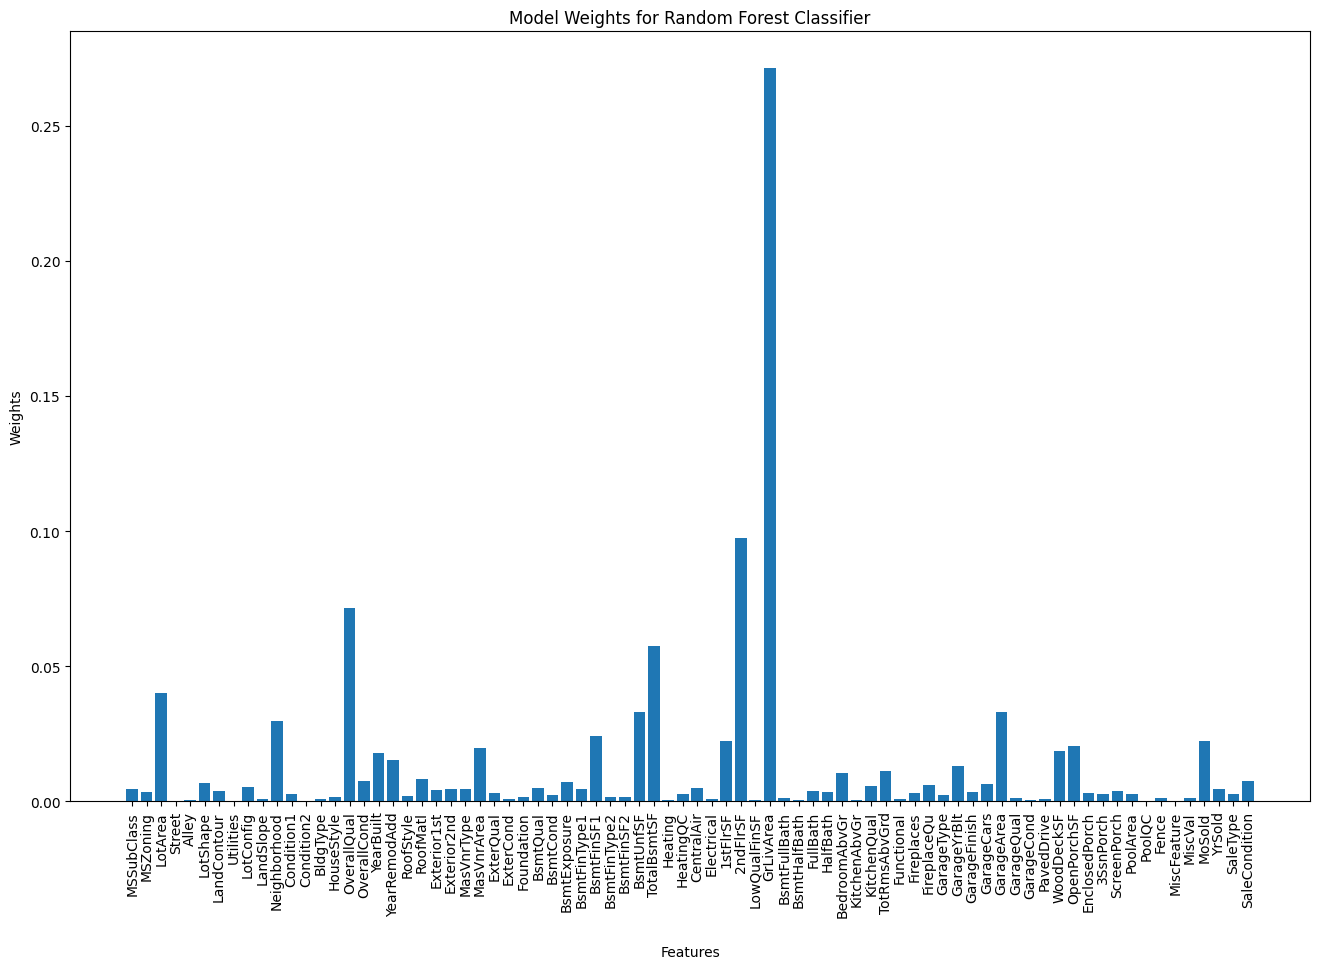

<Figure size 5000x5000 with 0 Axes>

In [29]:
rfr_tuned_importance = rfr_pipe.named_steps['randomforestregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(df_x.columns.to_list(),rfr_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for Random Forest Classifier')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### Random Forest on PCA

In [30]:
rfr_pipe_pca = make_pipeline(RandomForestRegressor())
rfr_pipe_pca.fit(X_train_pca, y_train)

y_pred_rfr_pca = rfr_pipe_pca.predict(X_test_pca)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, y_pred_rfr_pca, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.40030898580463853


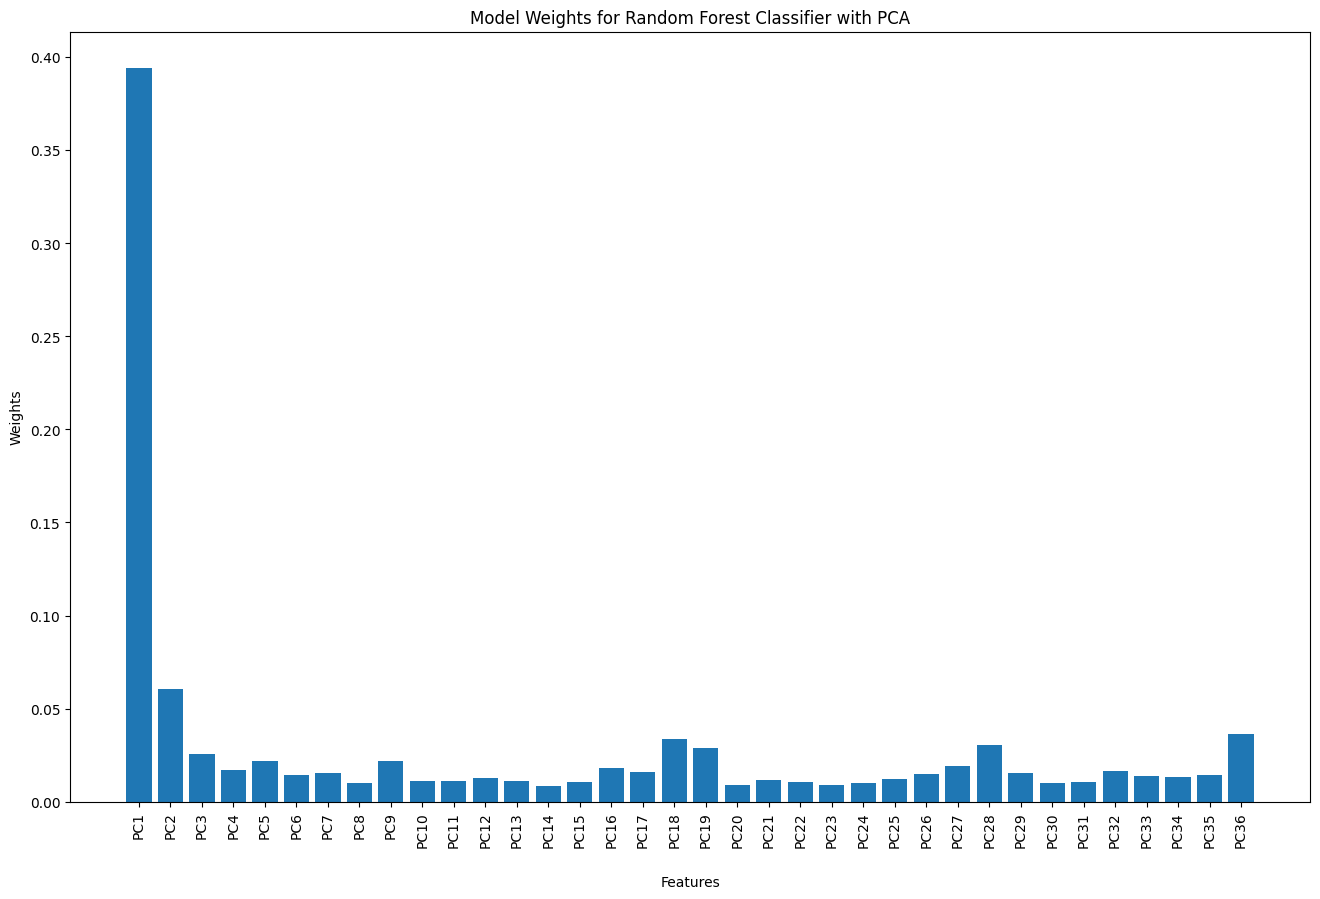

<Figure size 5000x5000 with 0 Axes>

In [31]:
pca_columns=['PC' + str(i + 1) for i in range(n_components)]
rfr_pca_tuned_importance = rfr_pipe_pca.named_steps['randomforestregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,rfr_pca_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for Random Forest Classifier with PCA')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### XGBoost on original data

In [32]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline

xgb_pipe = make_pipeline(XGBRegressor())
xgb_pipe.fit(X_train, y_train)
xgbc_y_pred = xgb_pipe.predict(X_test)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, xgbc_y_pred, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.20236548937597895


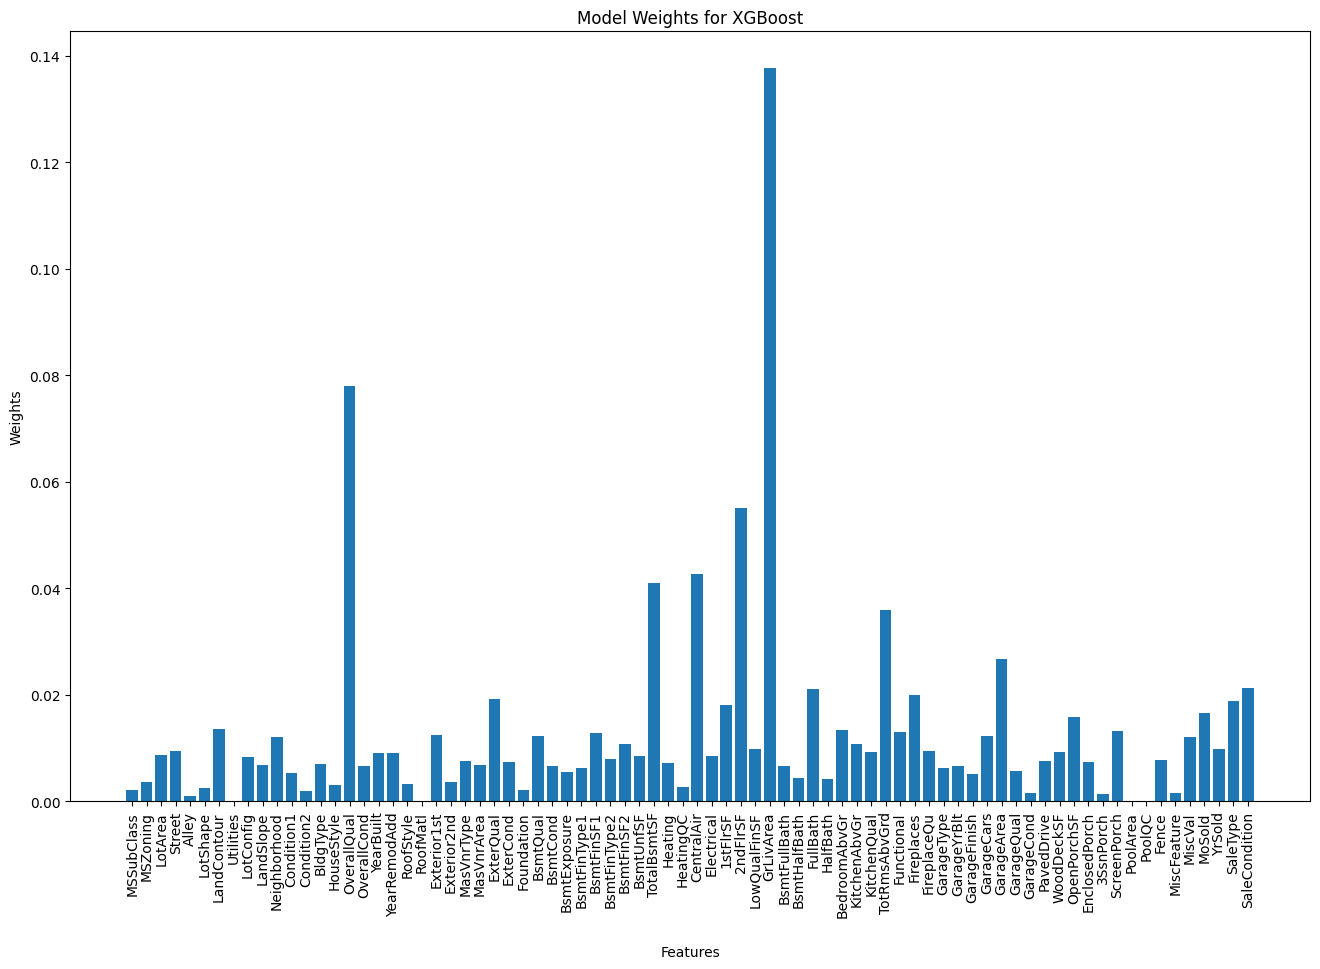

<Figure size 5000x5000 with 0 Axes>

In [33]:
xgb_tuned_importance = xgb_pipe.named_steps['xgbregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(df_x.columns.to_list(),xgb_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for XGBoost')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### XGBoost on PCA

In [34]:
xgb_pipe_pca = make_pipeline(XGBRegressor())
xgb_pipe_pca.fit(X_train_pca, y_train)
xgbc_y_pred_pca = xgb_pipe_pca.predict(X_test_pca)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, xgbc_y_pred_pca, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.3865684815622464


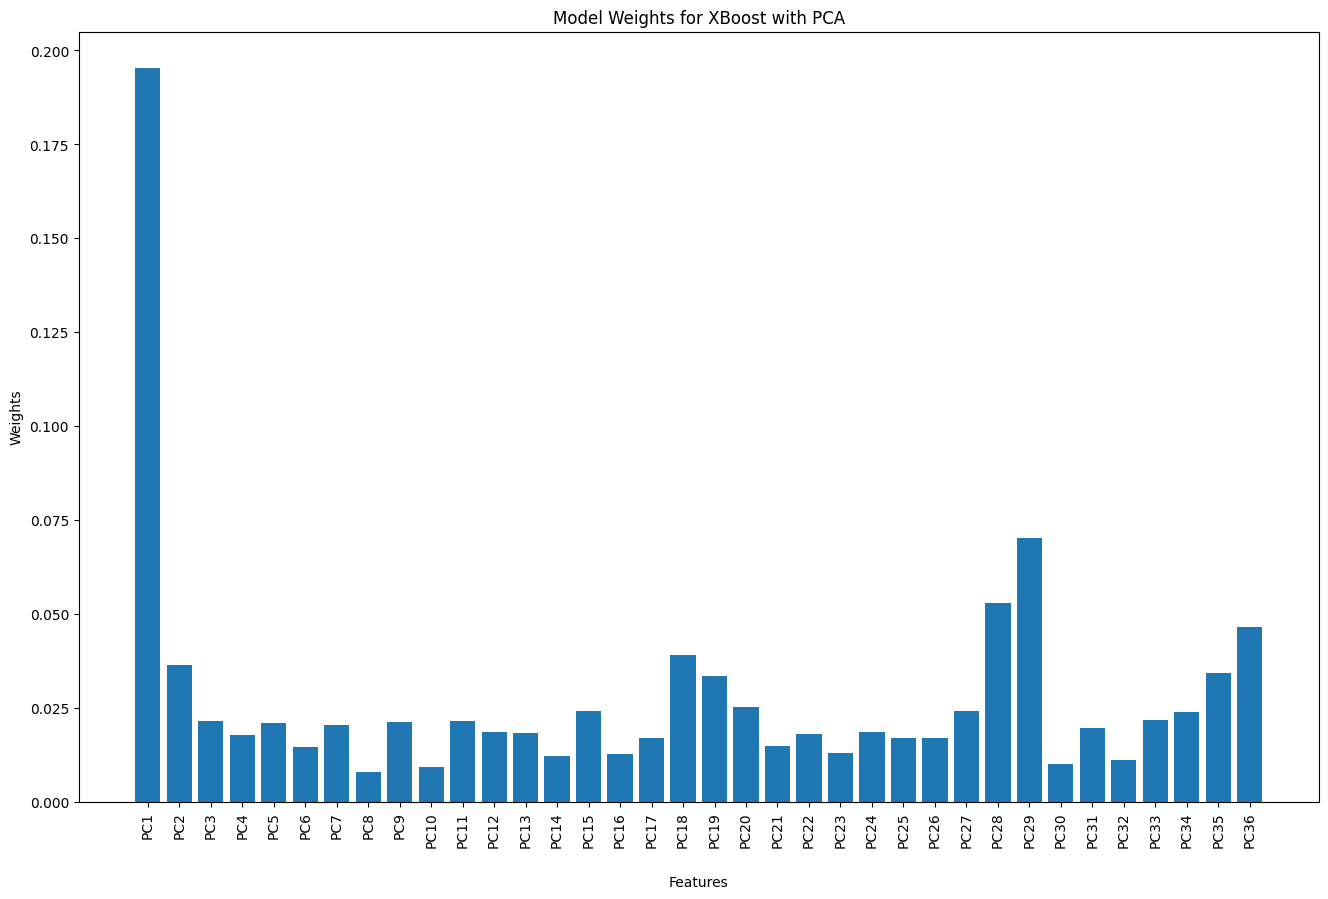

<Figure size 5000x5000 with 0 Axes>

In [35]:
xgb_pca_tuned_importance = xgb_pipe_pca.named_steps['xgbregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,xgb_pca_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for XBoost with PCA')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()